# Simple aperture photometry

* stack a few raw images
* subtract median
* find peaks and sort
* get n brightest peaks
* save centroid location (smaller box)
* crop image location and get new peak locations
* do photometry
* measure background
* measure fwhm

In [1]:
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
import getpass

filedir='/home/'+getpass.getuser()+'/data/transit/hatp44_data'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()
len(file_list)

1456

get list of file per band 

In [2]:
from tqdm import tqdm
try:
    from astropy.io import fits as pf
except:
    import pyfits as pf
    
filters_in_config = 'g,r,z_s'.split(',')
bands = {}

for j in filters_in_config:
    #initialize dict with empty arrays
    j=j.strip(' ')
    bands[j]=[]
filters_in_hdr=[]
        
for i in tqdm(file_list):
    hdr = pf.getheader(i)
    filters_in_hdr.append(hdr['FILTER'])
    for j in filters_in_config:
        if hdr['FILTER'] == j:
            j=j.strip(' ')
            bands[j].append(i)

100%|██████████| 1456/1456 [00:07<00:00, 204.92it/s]


stack image    

In [3]:
from numpy import median

def stack_raw_image(image_list, skip_every=1):
    '''
    stack image using median to be used for detecting 
    source locations (i.e. target and ref stars)
    '''
    image_array = []
    for i in tqdm(image_list[::skip_every]):
        img = pf.getdata(i)
        image_array.append(img)
    stacked_image = median(image_array, axis=0)
    return stacked_image

In [4]:
stacked_image_g = stack_raw_image(bands['g'], skip_every=10)
stacked_image_r = stack_raw_image(bands['r'], skip_every=10)
stacked_image_z = stack_raw_image(bands['z_s'], skip_every=10)

100%|██████████| 38/38 [00:00<00:00, 163.59it/s]


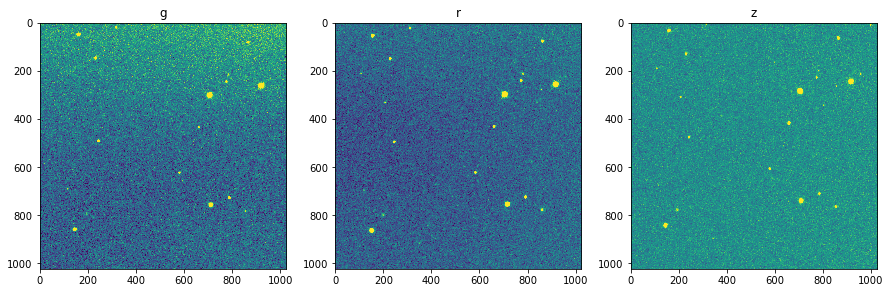

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.visualization import ZScaleInterval

fig, axes = plt.subplots(1,3,figsize=(15,5))
titles='g,r,z'.split(',')
for i,img in enumerate([stacked_image_g, stacked_image_r, stacked_image_z]):
    vmin,vmax= ZScaleInterval().get_limits(img)
    axes[i].imshow(img,vmin=vmin,vmax=vmax)
    axes[i].set_title(titles[i])

In [6]:
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats

def get_sources(img, num_stars=10, fwhm=8.0):
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=5.*std)  
    sources = daofind(img - median)
    #convert to pandas dataframe for easy sorting
    sources = sources.to_pandas()
    #sort by brightness
    sources = sources.sort_values(by='peak',ascending=False)
    
    return sources.head(num_stars)

In [7]:
sources = get_sources(stacked_image_g, num_stars=20)
sources.head(5)

,id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
7,8,702.821308,303.339113,0.447410,-0.038594,0.155101,121.0,0.0,29435.660156,464.017132,-6.666335
6,7,914.918542,263.888714,0.376185,-0.000529,0.152767,121.0,0.0,20157.964844,327.415155,-6.287747
14,15,707.375858,757.735332,0.447760,0.006841,0.095629,121.0,0.0,12683.524414,200.765599,-5.756723
16,17,143.778240,859.178913,0.378508,-0.204228,0.002376,121.0,0.0,6569.275391,115.454729,-5.156029
1,2,158.961490,52.121707,0.358547,-0.142429,0.152143,121.0,0.0,2671.650391,43.244263,-4.089821


In [8]:
from photutils import CircularAperture
from astropy.visualization import ZScaleInterval

def show_sources(image, sources, num_stars=10):
    '''
    similar to `show_peaks`; difference is `sources` used as input
    '''
    positions = (sources['xcentroid'].values[:num_stars], sources['ycentroid'].values[:num_stars])
    apertures = CircularAperture(positions, r=20.)
    vmin,vmax= ZScaleInterval().get_limits(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image, origin='lower', vmin=vmin,vmax=vmax)
    for num, (x,y) in enumerate(zip(positions[0],positions[1])):
        plt.text(x+5,y+5, num+1, fontsize=20, color='w')

    apertures.plot(color='r', lw=2)
    #return None

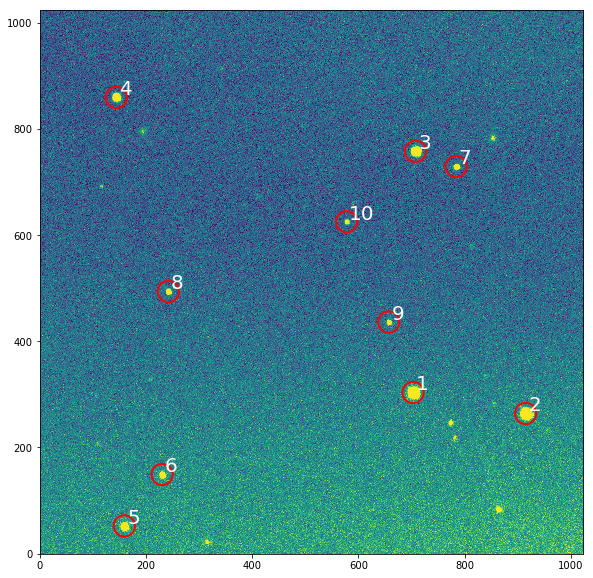

In [9]:
show_sources(stacked_image_g, sources, num_stars=10)

In [10]:
from photutils.detection import find_peaks
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture

def get_peaks(img, num_stars=10, box_size=10):
    '''
    Find local peaks in an image that are above above a specified
    threshold value.
    '''
    mean, median, std = sigma_clipped_stats(img, sigma=3.0, iters=5)
    threshold = median + (10.0 * std)
    tbl = find_peaks(img, threshold, box_size=box_size)
    #convert to pandas dataframe for easy sorting
    tbl = tbl.to_pandas()
    #sort by brightness
    tbl = tbl.sort_values(by='peak_value',ascending=False)
    return tbl.head(num_stars)

In [11]:
peaks = get_peaks(stacked_image_g)
peaks.head()

,x_peak,y_peak,peak_value
5,702,304,32550.894531
4,914,265,24078.945312
10,707,759,15519.871094
11,143,860,9433.503906
0,158,53,4807.112305


In [12]:
def show_peaks(image, peaks, num_stars=10):
    '''
    similar to `show_sources`; difference is `peaks` used as input
    '''
    positions = (peaks['x_peak'].values[:num_stars], peaks['y_peak'].values[:num_stars])
    apertures = CircularAperture(positions, r=20.)
    vmin,vmax= ZScaleInterval().get_limits(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image, origin='lower', vmin=vmin,vmax=vmax)
    for num, (x,y) in enumerate(zip(positions[0],positions[1])):
        plt.text(x+5,y+5, num+1, fontsize=20, color='w')

    apertures.plot(color='r', lw=2)
    #return None

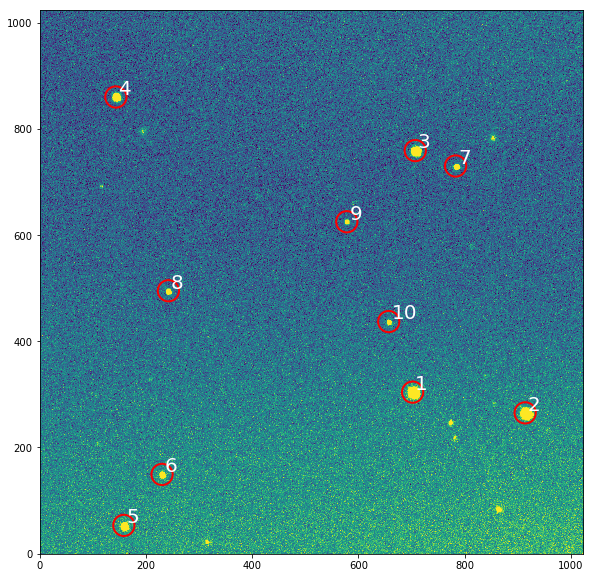

In [13]:
show_peaks(stacked_image_g, peaks, num_stars=10)

aperture photometry

In [14]:
from photutils import CircularAperture
import numpy as np
from photutils import aperture_photometry


def get_phot2(image, peaks, aperture_radii):
    '''
    similar to `show_sources`; difference is `peaks` used as input
    '''    
    positions = zip(peaks['x_peak'].values, peaks['y_peak'].values)
    apertures = [CircularAperture(positions, r=r) for r in aperture_radii]
    phot_table = aperture_photometry(image, apertures)
    #convert to pandas dataframe
    '''
    bug: Cannot convert a table with mixin columns to a pandas DataFrame
    '''
    #phot_table = phot_table.to_pandas()
    return phot_table

In [18]:
get_phot2(stacked_image_g, peaks, aperture_radii=np.arange(10,30,5))

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3
,pix,pix,,,,
int64,float64,float64,float64,float64,float64,float64
1,702.0,304.0,2079898.8093,2805522.39797,3767978.30552,4997299.47086
2,914.0,265.0,1751415.75732,2478951.65751,3442439.18861,4674711.56232
3,707.0,759.0,1190639.18376,1879657.18413,2823122.24327,4033807.44495
4,143.0,860.0,876409.669869,1553589.51149,2494054.18156,3700921.55818
5,158.0,53.0,705651.531925,1395192.67502,2356727.40024,3592122.17062
6,230.0,149.0,602437.152944,1287512.73317,2244854.78097,3476304.40332
7,783.0,730.0,585570.082484,1258232.10448,2198095.28017,3407431.57819
8,242.0,495.0,572501.094519,1246918.39844,2189851.96095,3402420.83187


test loop

In [ ]:
for 

In [19]:
from photutils import CircularAperture
import numpy as np
from photutils import aperture_photometry

def get_phot(image, centroid, aperture_radii):
    '''
    similar to `show_sources`; difference is `peaks` used as input
    '''    
    apertures = [CircularAperture(centroid, r=r) for r in aperture_radii]
    phot_table = aperture_photometry(image, apertures)
    #convert to pandas dataframe
    '''
    bug: Cannot convert a table with mixin columns to a pandas DataFrame
    '''
    #phot_table = phot_table.to_pandas()
    return phot_table

In [20]:
def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

In [21]:
from photutils import centroid_com, centroid_1dg, centroid_2dg

def get_centroid(image, method='2d_gaussian'):
    '''
    centroid_com(): Calculates the object “center of mass” from 2D image moments.
    centroid_1dg(): Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
    centroid_2dg(): Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.
    Default is centroid_2dg.
    ''' 
    if method=='com':
        x, y = centroid_com(image)
        return x,y
    
    elif method=='1d_gaussian':
        x, y = centroid_1dg(image)
        return x,y
    else: #default
        x, y = centroid_2dg(image)
        return x,y

In [40]:
def make_lightcurve(band_list, star_positions, aperture_radii, skip_every=1):
    obs_mjd = []
    xcenters, ycenters = [], []
    flux_at_r = {}
    frames={}
    for star_idx, position in enumerate(star_positions):
        tables=[]
        print('performing aperture photometry on star index: {}'.format(star_idx))
        print('initial centroid: {}'.format(star_positions[star_idx]))
        #each star position determined from the stacked image
        for i in band_list[::skip_every]:
            #each image in a given band
            image = pf.getdata(i)
            hdr = pf.getheader(i)
            obs_mjd.append(hdr['MJD-STRT'])
            #crop
            img_crop = get_crop(image, position, box_size=40)
            #compute new centroid
            new_centroid = get_centroid(img_crop, method='2d_gaussian')
            #perform photometry
            phot_table = get_phot(img_crop, new_centroid, aperture_radii=aperture_radii)
            xcenters.append(phot_table['xcenter'])
            ycenters.append(phot_table['xcenter'])
            #add time
            import pdb; pdb.set_trace()
            phot_table['time'] = obs_mjd
            tables.append(phot_table)
                
        
        df=pd.DataFrame(flux_at_r,index = obs_mjd)
        names=[]
        for r in aperture_radii:
            names.append('star_{0}_r_{1}'.format(star_idx,r))
        df.columns = names
        
        #import pdb; pdb.set_trace()
        frames[star_idx] = df
    
    return frames

In [41]:
#star_positions = zip(peaks['x_peak'].values, peaks['y_peak'].values)
star_positions = zip(sources['xcentroid'].values, sources['ycentroid'].values)
skip_every=100
band_list=bands['g']
aperture_radii=np.arange(10,30,5)

result = make_lightcurve(band_list, star_positions[:3], aperture_radii, skip_every=100)

performing aperture photometry on star index: 0
initial centroid: (702.82130824352134, 303.33911260721948)
> <ipython-input-40-0b875f9e57b8>(26)make_lightcurve()
-> phot_table['time'] = obs_mjd
(Pdb) phot_table['time'] = obs_mjd
(Pdb) phot_table
<QTable length=1>
  id     xcenter       ycenter    ... aperture_sum_3      time    
           pix           pix      ...                             
int64    float64       float64    ...    float64        float64   
----- ------------- ------------- ... -------------- -------------
    1 22.5690375592 20.1109519918 ...  5059903.19711 57799.5960012
(Pdb) tables.append(phot_table)
(Pdb) c
> <ipython-input-40-0b875f9e57b8>(25)make_lightcurve()
-> import pdb; pdb.set_trace()
(Pdb) c


ValueError: could not broadcast input array from shape (2) into shape (1)